<h1 align="center">Prediction of the band gap of semiconductor</h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

#!pip install catboost

from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# **Dataset**  
### Информация о датасете:  
#### 1. formula_pretty - просто формула
#### 2. elements - список входящих элементов таблицы Менделеева
#### 3. num_elements - количество атомов разного типа
#### 4. composition - формула
#### 5. composition_reduced - сокращённая формула
#### 6. nsites - количество атомов в элементарной ячейке
#### 7. volume - объём элементарной ячейки в Å
#### 8. density - плотность в г/см^3
#### 9. band_gap - ширина запрещённой зоны полупроводника в эВ
#### 10. energy_per_atom - внутренняя энергия в эВ/атом
#### 11. efermi - уровень Ферми в эВ.
#### 12. energy_above_hull - высота над convex hull в эВ/атом.
#### 13. formation_energy_per_atom - энтальпия образования в эВ/атом.
#### 14. crystal_system - сингония
#### 15. space_group_number - номер группы симметрии 
#### 16. lattice - вектора кристаллической решётки , каждое число в Å
#### 17. fractional_coordinates - относительные координаты атомов 3хN, N - число атомов
#### 18. species - последовательность элементов для атомов 1xN, в том же порядке что и fractional_coordinates


In [2]:
df = pd.read_csv('/kaggle/input/materials/materials_dataset.csv')

#df.info()
pd.set_option('display.max_columns', None)
df.head()
#df.describe()

,formula_pretty,elements,num_elements,composition,composition_reduced,nsites,volume,density,band_gap,energy_per_atom,efermi,energy_above_hull,formation_energy_per_atom,crystal_system,spacegroup_number,lattice,frac_coords,species
0,Ti,Ti,1,Ti3,Ti1,3,51.059,4.670,0.0,-7.89549,5.88542,0.000000,0.00000,Hexagonal,191,4.567 0.0 0.0\n-2.284 3.955 0.0\n-0.0 0.0 2.826\n,"0.0, 0.0, 0.0\n0.333, 0.667, 0.5\n0.667, 0.333...",Ti\nTi\nTi
1,U,U,1,U2,U1,2,39.302,20.114,0.0,-11.29141,15.18229,0.000000,0.00000,Orthorhombic,63,2.771 0.0 -0.0\n-1.385 2.925 0.0\n0.0 0.0 4.85\n,"0.096, 0.193, 0.75\n0.904, 0.807, 0.25",U\nU
2,B,B,1,B1,B1,1,9.125,1.967,0.0,-5.97209,4.13479,0.707305,0.70731,Hexagonal,191,-0.0 -0.0 3.635\n1.702 0.0 -0.0\n-0.851 1.474 ...,"0.0, 0.0, 0.0",B
3,Ce,Ce,1,Ce4,Ce1,4,103.681,8.976,0.0,-5.89025,9.06270,0.042839,0.04284,Hexagonal,194,3.321 0.0 0.0\n-1.66 2.876 -0.0\n0.0 0.0 10.856\n,"0.0, 0.0, 0.0\n0.0, 0.0, 0.5\n0.333, 0.667, 0....",Ce\nCe\nCe\nCe
4,U,U,1,U6,U1,6,125.244,18.935,0.0,-11.00997,14.37829,0.281440,0.28144,Monoclinic,15,3.561 4.161 0.0\n-3.561 4.161 0.0\n0.0 3.654 4...,"0.179, 0.821, 0.25\n0.821, 0.179, 0.75\n0.196,...",U\nU\nU\nU\nU\nU


# **Feature engineering and selection**  
### 1. Перевод химической формулы в числовой признак:  
 #### formula_pretty, composition, composition_reduced + elements --> каждый химический элемент стал новым столбецом 
 #### - В частности изпользовали метод Bag-of-words для обработки текстовых данных 
<img src="https://kartinkof.club/uploads/posts/2022-03/1648301803_2-kartinkof-club-p-mem-kot-dumaet-2.jpg" width=400>

In [3]:
#feature - elements

from functools import reduce
import re

df.dropna(inplace=True) #remove missing values

elements = [item.split(', ') for item in df['elements'].values]

df['elements'] = elements

dictionary = list(enumerate(set(reduce(lambda x, y: x + y, elements))))

text = df['composition'].values
text = [item.split(' ') for item in text]

res = []
for t in text:
  res.append([re.match("([a-zA-Z]+)([0-9]+)", test_str).groups() for test_str in t])

for k,v in dictionary:
    df[v] = np.zeros(len(df))

count = 0
def vectorize(res):    
    global count
    vector = np.zeros(len(dictionary))
    for i, word in dictionary:
        num = 0
        for tup in res:
          first, second = tup
          if first == word:
            num += int(second)
          if num > 0:
            df.at[count, word] = num
            vector[i] = num
            num = 0
    count += 1
    return vector

fin = list(map(vectorize, res))

df.dropna(inplace=True)

df['composition'] = fin

#df.head(22972)

### 2. Убрали обработанные признаки и те, что не поддаются обработке
<img src="https://www.meme-arsenal.com/memes/19786207ec838f77c062da77825af1af.jpg" width="350">

In [4]:
#We select data using common sense

df = df.drop('formula_pretty', axis=1)
df = df.drop('elements', axis=1)
df = df.drop('composition', axis=1)
df = df.drop('composition_reduced', axis=1)

df = df.drop('lattice', axis=1)
df = df.drop('frac_coords', axis=1)
df = df.drop('species', axis=1)

pd.set_option('display.max_columns', None)
df.head()

,num_elements,nsites,volume,density,band_gap,energy_per_atom,efermi,energy_above_hull,formation_energy_per_atom,crystal_system,spacegroup_number,Li,Os,Pb,Ge,Lu,Sc,Te,Cl,Ce,Re,Ca,Cs,V,Mn,Si,Ir,Y,Nd,Ag,Th,Zr,Na,Br,Gd,Pu,K,W,Fe,Tb,Ga,Pm,Ni,Sr,Pr,N,Bi,Pt,Nb,Cu,Ti,Tl,Pd,Pa,F,Ba,O,Yb,Ru,B,S,Al,Rh,Dy,Zn,Sm,Tc,Cr,Ho,Hg,Tm,In,Hf,I,Np,Se,Kr,Sb,Be,Sn,Ar,Ta,Co,La,U,H,P,Cd,Ac,Eu,As,Er,Mo,Rb,Au,Xe,Mg,C
0,1.0,3.0,51.059,4.670,0.0,-7.89549,5.88542,0.000000,0.00000,Hexagonal,191.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,2.0,39.302,20.114,0.0,-11.29141,15.18229,0.000000,0.00000,Orthorhombic,63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,9.125,1.967,0.0,-5.97209,4.13479,0.707305,0.70731,Hexagonal,191.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,4.0,103.681,8.976,0.0,-5.89025,9.06270,0.042839,0.04284,Hexagonal,194.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,6.0,125.244,18.935,0.0,-11.00997,14.37829,0.281440,0.28144,Monoclinic,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# **Correlation matrix**  
### Перешли к отбору численных признаков
<img src="https://ding.se/wp/wp-content/uploads/2019/06/Maskininlarning-2.jpg" width="350px">

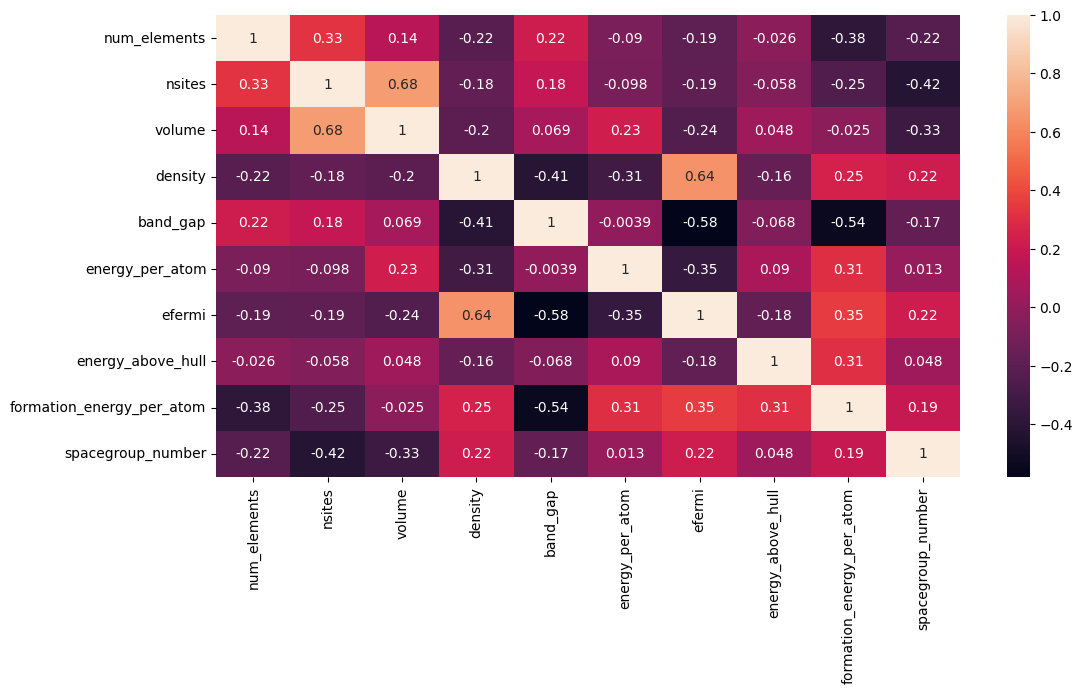

In [5]:
columns = [col for col in df.columns[0:11] if col != 'crystal_system']
#print(columns)

df_c = df[columns].copy()
corrMatrix = df_c.corr()

plt.figure(figsize=(12, 6))

sns.heatmap(corrMatrix, annot=True)
plt.show()

### Исходя из корреляционной матрицы, сделали вывод, что наиболее значимыми признаками являются уровень Ферми (efermi), энтальпия образования (formation_energy_per_atom) и плотность (density). 
### Проверим данные выводы после обучения модели.

# **CatBoost**
### *Открытая программная библиотека, разработанная компанией Яндекс и реализующая уникальный патентованный алгоритм построения моделей машинного обучения, использующий одну из оригинальных схем градиентного бустинга.*
<img src="https://camo.githubusercontent.com/e038bfd04da9b8d08001163173d8412589f6f3d68dc566460f5063e9002587c7/68747470733a2f2f6d6574726f2e636f2e756b2f77702d636f6e74656e742f75706c6f6164732f323031352f30332f61645f3136323735343239342e6a70673f7175616c6974793d39302673747269703d616c6c" width="550px">

In [6]:
from catboost import Pool

cat = CatBoostRegressor()

y = df['band_gap']
X = df.drop('band_gap', axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.25, 
                                                    random_state = 0)
cat_features = ['crystal_system']
train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)

cat.fit(train_pool, eval_set=test_pool, verbose=100, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.079613
0:	learn: 1.3119577	test: 1.2969509	best: 1.2969509 (0)	total: 76.7ms	remaining: 1m 16s
100:	learn: 0.7303370	test: 0.7696777	best: 0.7696777 (100)	total: 1.26s	remaining: 11.2s
200:	learn: 0.6700894	test: 0.7404725	best: 0.7404512 (199)	total: 2.34s	remaining: 9.31s
300:	learn: 0.6224142	test: 0.7216660	best: 0.7216660 (300)	total: 3.44s	remaining: 7.99s
400:	learn: 0.5926121	test: 0.7139754	best: 0.7138945 (399)	total: 4.54s	remaining: 6.78s
500:	learn: 0.5672262	test: 0.7076531	best: 0.7076385 (499)	total: 5.68s	remaining: 5.66s
600:	learn: 0.5460956	test: 0.7039551	best: 0.7039551 (600)	total: 6.98s	remaining: 4.63s
700:	learn: 0.5273087	test: 0.7013875	best: 0.7010055 (657)	total: 8.07s	remaining: 3.44s
800:	learn: 0.5107326	test: 0.6990362	best: 0.6990362 (800)	total: 9.27s	remaining: 2.3s
900:	learn: 0.4964253	test: 0.6977633	best: 0.6976891 (891)	total: 10.4s	remaining: 1.14s
999:	learn: 0.4817332	test: 0.6953716	best: 0.6952960 (997)	total: 11.5s	

Mean of actual values :  0.6883749259968658
Mean of predicted values:  0.6969838816244328


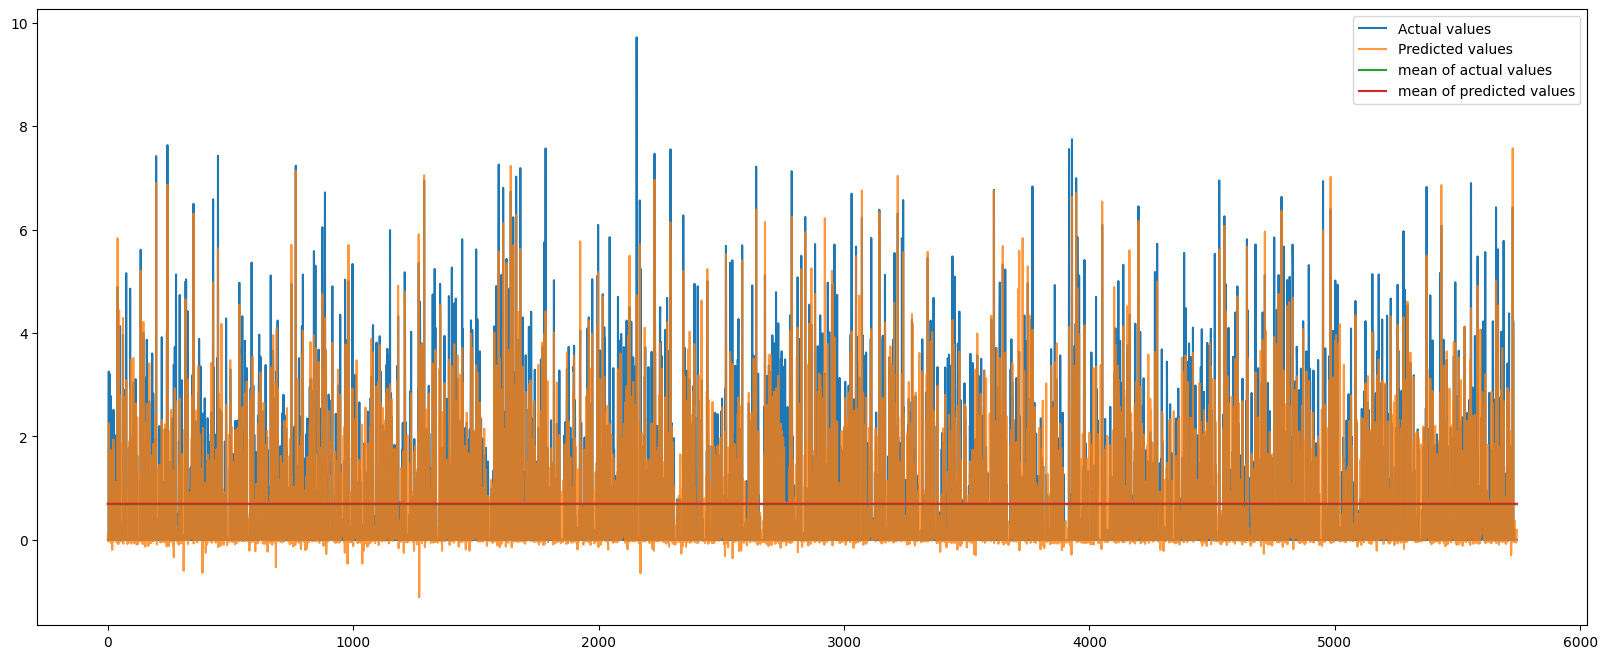

In [7]:
y_pred = cat.predict(test_pool)

print("Mean of actual values : ", y_test.mean())
print("Mean of predicted values: ", y_pred.mean())

# fitting the size of the plot
plt.figure(figsize=(20, 8))

# plotting the graphs
plt.plot([i for i in range(len(y_test))],y_test, label="Actual values", alpha=1)
plt.plot([i for i in range(len(y_test))],y_pred, label="Predicted values", alpha=0.8)
plt.plot([i for i in range(len(y_test))],[y_test.mean() for x in range(len(y_test))], label = "mean of actual values")
plt.plot([i for i in range(len(y_test))],[y_pred.mean() for y in range(len(y_test))], label = 'mean of predicted values')

# showing the plotting
plt.legend()
plt.show()

# **Evaluating the model**
### Оценили модель, используя в качестве показателя ошибки $R^2$-метрику

In [8]:
from sklearn.metrics import r2_score, mean_squared_error
# Evaluating the model

print('R-square score is :', r2_score(y_test, y_pred))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))

R-square score is : 0.7369174871161008
RMSE:  0.6952960197994554


# **Optimal parameters searching**
### Попробуем подобрать оптимальные параметры для CatBoostRegressor()
<img src="https://aroundpet.ru/wp-content/uploads/racion-vzrosloj-koshki-1170x715.jpg" width="550px">

In [9]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from sklearn.model_selection import GridSearchCV, cross_val_score

params = {
    'depth': np.arange(2, 6),
    'learning_rate': np.logspace(-4, 0, 5).tolist() + [None]
}

gs = GridSearchCV(
    estimator=CatBoostRegressor(random_seed=0, cat_features=cat_features, verbose=False),
    scoring='neg_mean_squared_error',
    param_grid=params,
    cv=3,
    n_jobs=-2,
)

gs.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x7b792aab69b0>,
             n_jobs=-2,
             param_grid={'depth': array([2, 3, 4, 5]),
                         'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0,
                                           None]},
             scoring='neg_mean_squared_error')

In [10]:
preds = gs.predict(X_test)
# Evaluating the model

print(f"R-square score is : {r2_score(y_test, preds):.3f}")
print(f"RMSE = {mean_squared_error(y_test, preds) ** 0.5:.3f}")

R-square score is : 0.732
RMSE = 0.701


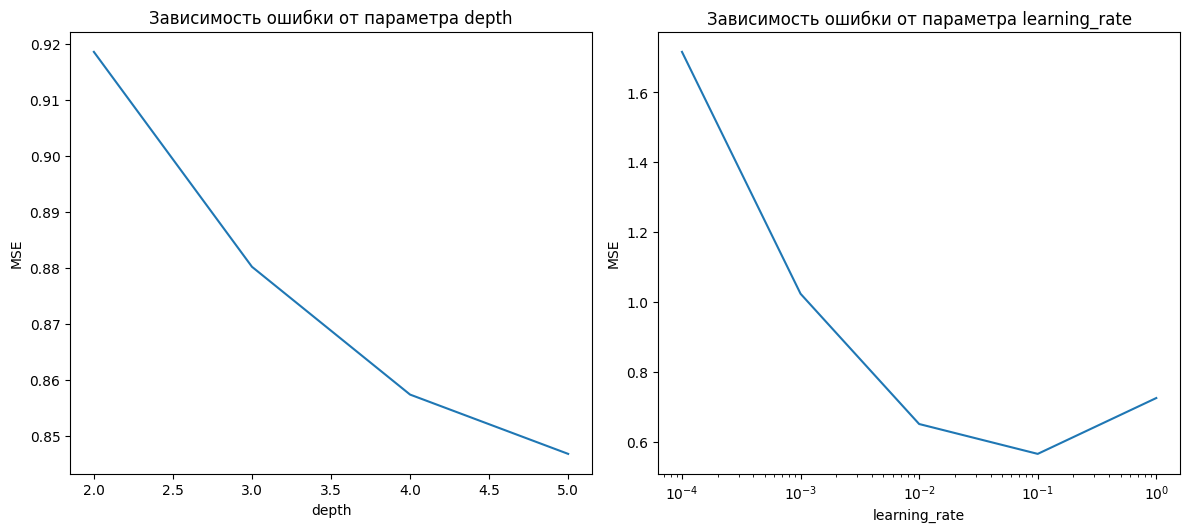

In [11]:
scores = pd.DataFrame(gs.cv_results_['params'])

score = pd.DataFrame([{'score': score} for score in gs.cv_results_['mean_test_score']])
scores['score'] = -score['score']

params['learning_rate'] = params['learning_rate'][:-1]

plt.figure(figsize=(12, 10))

for i, param in enumerate(params):
    plt.subplot(len(params) // 2 + 1, 2, i + 1)
    loss = scores.groupby(param)['score'].mean().values.tolist()

    plt.plot(params[param], loss)
    plt.title(f'Зависимость ошибки от параметра {param}')
    if param == 'learning_rate':
        plt.xscale('log')
    plt.xlabel(param)
    plt.ylabel('MSE')
plt.tight_layout()
plt.show()

# **Best model results**
### После подбора оптимальных параметров можем выбрать 'лучшую' модель. Посмотрим на топ важности признаков по результатам её обучения:
<img src="https://mobimg.b-cdn.net/v3/fetch/bc/bc4f876ac17d12084523776931265d82.jpeg" width="500px">

In [12]:
best_cat = gs.best_estimator_
best_cat.fit(train_pool, eval_set=test_pool, verbose=100, plot=True)
res = best_cat.get_feature_importance(prettified=True)
res.head(10)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.3025600	test: 1.2882614	best: 1.2882614 (0)	total: 14.4ms	remaining: 14.4s
100:	learn: 0.7403053	test: 0.7755684	best: 0.7754652 (99)	total: 931ms	remaining: 8.29s
200:	learn: 0.6806176	test: 0.7433446	best: 0.7433446 (200)	total: 1.82s	remaining: 7.22s
300:	learn: 0.6450871	test: 0.7310092	best: 0.7310092 (300)	total: 2.7s	remaining: 6.27s
400:	learn: 0.6173758	test: 0.7236972	best: 0.7236972 (400)	total: 3.59s	remaining: 5.36s
500:	learn: 0.5943101	test: 0.7180481	best: 0.7180481 (500)	total: 4.52s	remaining: 4.5s
600:	learn: 0.5739205	test: 0.7137090	best: 0.7136157 (594)	total: 5.45s	remaining: 3.62s
700:	learn: 0.5550852	test: 0.7100230	best: 0.7099785 (699)	total: 6.34s	remaining: 2.7s
800:	learn: 0.5392733	test: 0.7067784	best: 0.7067784 (800)	total: 7.55s	remaining: 1.88s
900:	learn: 0.5257075	test: 0.7043557	best: 0.7040097 (869)	total: 8.48s	remaining: 931ms
999:	learn: 0.5135922	test: 0.7011989	best: 0.7011989 (999)	total: 9.41s	remaining: 0us

bestTest = 0.70119

,Feature Id,Importances
0,efermi,28.845915
1,formation_energy_per_atom,25.007215
2,energy_above_hull,10.590497
3,density,10.122312
4,energy_per_atom,7.767934
5,volume,4.203438
6,spacegroup_number,3.746406
7,nsites,2.953706
8,num_elements,1.404800
9,crystal_system,1.199865


# **SHAP visualization**
### Визуализируем влияние признаков на результат предсказания целевой переменной с помощью библиотеки SHAP. В данной библиотеке для оценки важности фичей рассчитываются значения Шэпли. Оцениваем предсказание модели с и без данной фичи.
<img src="https://hsto.org/getpro/habr/formulas/f64/790/f77/f64790f77a29e45a796732d4d5aef8bb.svg" width="550px">

### $p(S \cup \{ i \})$ — это предсказание модели с i-той фичей,
### $p(S)$ — это предсказание модели без i-той фичи,
### $n$ — количество фичей,
### $S$ — произвольный набор фичей без i-той фичи


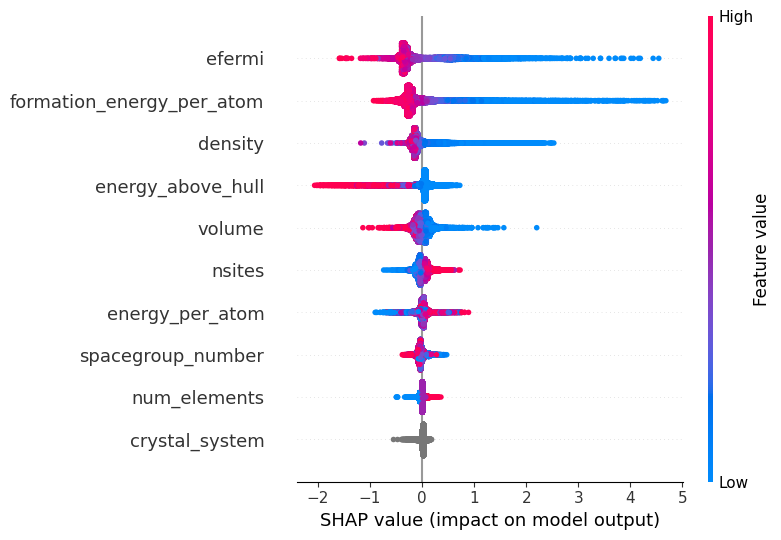

In [13]:
import shap

explainer = shap.TreeExplainer(best_cat)
shap_values=explainer.shap_values(Pool(X, y, cat_features=cat_features))

shap.summary_plot(shap_values[:,0:10], X.iloc[:, 0:10])

# **Thank you for your attention!**
### Credits to: *https://github.com/ScarrryMary*
<img src="https://kartinkof.club/uploads/posts/2022-03/1648329591_1-kartinkof-club-p-kot-s-ulibkoi-mem-1.jpg" width="300px">